# Rebinning opacities

Intrinsically, pRT has two different opacity treatments. One makes use of the so-called correlated-k assumption (`line_opacity_mode='c-k'` when instantiating a `Radtrans` object), and allows you to calculate spectra at a default wavelength binning of $\lambda / \Delta \lambda = 1000$. The other treatment is the so-called line-by-line method (`line_opacity_mode='lbl'`), and allows you to calculate specra at default binning of $\lambda / \Delta \lambda = 10^6$.

Sometimes you may want to calculate spectra at a larger wavelength spacing, however, say at $\lambda / \Delta \lambda = 150$ in the `c-k` mode, or at $\lambda / \Delta \lambda = 250,000$ in `lbl` mode. Of course it is possible to run calculations at high intrinsic resolution first, and then bin down, but this is numerically inefficient. This is why you can easily specify lower resolutions in the retrieval package of pRT, [see the tutorial here](pRT_Retrieval_Example.html). Here we show you how to specifiy resolutions outside of the retrieval subpackage.

## Binning opacities in `c-k` mode

To run at a larger wavelength binning (so "lower resolution") in `c-k` mode, just create a pRT object as usual, but this time add, for example, `'.R100'` to the requested line species name. In this case the effective wavelength binning would be changed to $\lambda / \Delta \lambda = 100$. What happens inside pRT is that it will look whether such a binned down opacity file already exists in your `input_data` folder. If it does, it will simply read it in. If it does not exist, the opacities will be binned to lower resolution and a corresponding file will be saved to the `input_data` folder. So if you rebin to many different resolutions for many different species, your `input_data` folder will grow. You may check its size from time to time and remove those resolution files that you no longer need (you can always recreate them at a small computational overhead when creating a pRT object).

<div class="alert alert-info">

For binning opacities down in `'c-k'` mode we use the [exo-k](https://perso.astrophy.u-bordeaux.fr/~jleconte/exo_k-doc/index.html) package. Please cite it and the corresponding paper [(Leconte et al. 2021)](https://ui.adsabs.harvard.edu/abs/2021A%26A...645A..20L/abstract) if you make use of this functionality in pRT.

</div>

So here we create a pRT object like in the [Getting Started](getting_started.html) example, but at $\lambda / \Delta \lambda = 100$:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from petitRADTRANS.radtrans import Radtrans

atmosphere = Radtrans(pressures = np.logspace(-6,2,100),
                      line_species = ['H2O.R100', 
                                      'CO-NatAbund.R100', 
                                      'CH4.R100', 
                                      'CO2.R100', 
                                      'Na.R100',
                                      'K.R100'],
                      rayleigh_species = ['H2', 'He'],
                      gas_continuum_contributors = ['H2-H2', 'H2-He'],
                      wavelength_boundaries = [0.3, 15])

Rebinning file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5' to R = 100...  Done.
 Writing binned down file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R100_0.3-50mu.ktable.petitRADTRANS.h5'...  Done.
Successfully binned down k-table into '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R100_0.3-50mu.ktable.petitRADTRANS.h5' (R = 100)
Loading Radtrans opacities...
File '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R100_0.3-50mu.ktable.petitRADTRANS.h5' already exists, skipping re-binning...
 Loading line opacities of species 'H2O.R100' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R100_0.3-50mu.ktable.petitRADTRANS.h5'... D

Now, as you would see when running it again, making the pRT object a second time will be faster, and with less output, since the opacities have already been binned to lower resolution:

In [3]:
atmosphere = Radtrans(pressures = np.logspace(-6,2,100),
                      line_species = ['H2O.R100', 
                                      'CO-NatAbund.R100', 
                                      'CH4.R100', 
                                      'CO2.R100', 
                                      'Na.R100',
                                      'K.R100'],
                      rayleigh_species = ['H2', 'He'],
                      gas_continuum_contributors = ['H2-H2', 'H2-He'],
                      wavelength_boundaries = [0.3, 15])

File '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R100_0.3-50mu.ktable.petitRADTRANS.h5' already exists, skipping re-binning...
Loading Radtrans opacities...
File '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R100_0.3-50mu.ktable.petitRADTRANS.h5' already exists, skipping re-binning...
 Loading line opacities of species 'H2O.R100' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R100_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
File '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R100_0.1-250mu.ktable.petitRADTRANS.h5' already exists, skipping re-binning...
 Loading line opacities of species 'CO-NatAbund.R100' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbun

For comparison, we will create also a nominal opacity resolution object.

In [4]:
atmosphere_nominal_binning = Radtrans(pressures = np.logspace(-6,2,100),
                                      line_species = ['H2O', 
                                                      'CO-NatAbund', 
                                                      'CH4', 
                                                      'CO2', 
                                                      'Na',
                                                      'K'],
                                      rayleigh_species = ['H2', 'He'],
                                      gas_continuum_contributors = ['H2-H2', 'H2-He'],
                                      wavelength_boundaries = [0.3, 15])

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/Users/molliere/Desktop/input_data_v3/inp

Let's quickly calculate the getting started example to compare the two results:

Text(0, 0.5, 'Transit radius [$\\rm R_{Jup}$]')

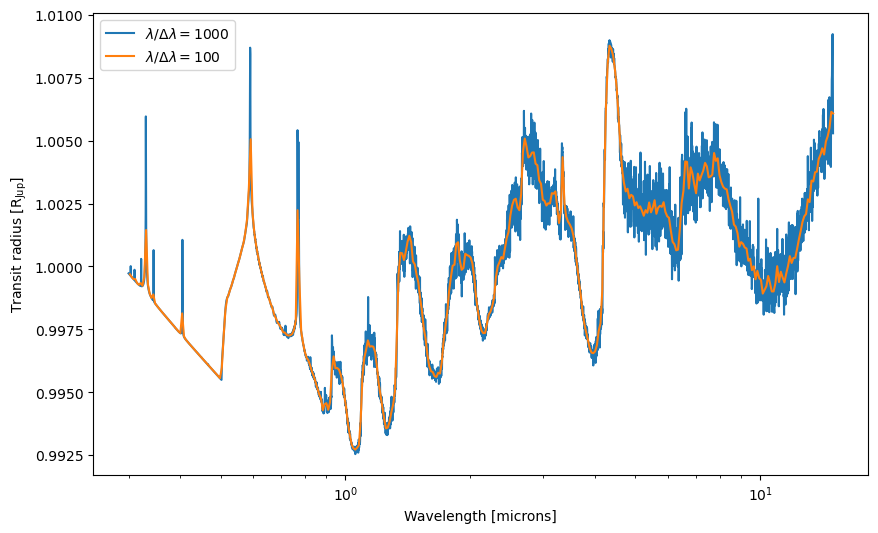

In [9]:
from petitRADTRANS import physical_constants as cst
temperatures = 1200. * np.ones_like(atmosphere.pressures) # note that pressures is in cgs units now, multiply by 1e-6 to get bars.

mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperatures)
mass_fractions['He'] = 0.24 * np.ones_like(temperatures)
mass_fractions['H2O'] = 1e-3 * np.ones_like(temperatures)
mass_fractions['CO-NatAbund'] = 1e-2 * np.ones_like(temperatures)
mass_fractions['CO2'] = 1e-4 * np.ones_like(temperatures)
mass_fractions['CH4'] = 1e-5 * np.ones_like(temperatures)
mass_fractions['Na'] = 1e-4 * np.ones_like(temperatures)
mass_fractions['K'] = 1e-6 * np.ones_like(temperatures)

            #  2.33 is a typical value for H2-He dominated atmospheres
mean_molar_masses = 2.33 * np.ones_like(temperatures)

planet_radius = 1.0*cst.r_jup_mean
reference_gravity = 10**3.5
reference_pressure = 0.01

wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure)

wavelengths_nominal_binning, transit_radii_nominal_binning, _ = atmosphere_nominal_binning.calculate_transit_radii(
                                                                                temperatures=temperatures, 
                                                                                mass_fractions=mass_fractions, 
                                                                                mean_molar_masses=mean_molar_masses, 
                                                                                reference_gravity=reference_gravity, 
                                                                                planet_radius=planet_radius, 
                                                                                reference_pressure=reference_pressure)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths_nominal_binning*1e4,
        transit_radii_nominal_binning/cst.r_jup_mean,
        label=r'$\lambda / \Delta \lambda=1000$')
ax.plot(wavelengths*1e4,
        transit_radii/cst.r_jup_mean,
        label=r'$\lambda / \Delta \lambda=100$')
ax.set_xscale('log')
plt.legend()
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'Transit radius [$\rm R_{Jup}$]')

And the numerically calculated resolution is consistent with what we requested:

Text(0, 0.5, '$\\lambda/\\Delta\\lambda$')

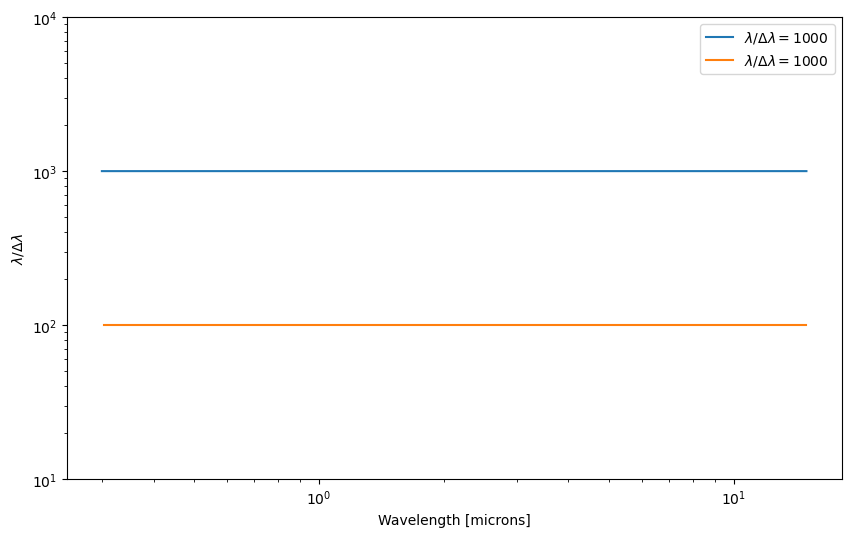

In [11]:
fig, ax = plt.subplots(figsize = (10,6))

mean_wavelength_nominal = (wavelengths_nominal_binning[1:] + wavelengths_nominal_binning[:-1])/2.
ax.plot(mean_wavelength_nominal*1e4,
        mean_wavelength_nominal/np.diff(wavelengths_nominal_binning),
        label=r'$\lambda / \Delta \lambda=1000$')
mean_wavelength = (wavelengths[1:] + wavelengths[:-1])/2.
ax.plot(mean_wavelength*1e4,
        mean_wavelength/np.diff(wavelengths),
        label=r'$\lambda / \Delta \lambda=1000$')
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim([1e1,1e4])
plt.legend()
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'$\lambda/\Delta\lambda$')

<div class="alert alert-warning">

Please note: **NEVER** mix line opacities of different resolutions for a single pRT object!

</div>

## Downsampling `lbl` opacities

In the line-by-line mode it is enough to just specify the desired downsampling factor. As pRT intrinsically has a spacing of $\lambda / \Delta \lambda = 10^6$, a spacing of $\lambda / \Delta \lambda = 250,000$ can be achieved when requesting a downsampling factor of $10^6/250,000 = 4$. This is then done by setting `line_by_line_opacity_sampling = 4` when creating the pRT object. We compare a nominal and downsampled case below, again by copying the [tutorial](highres.html):

In [19]:
atmosphere_high_res = Radtrans(pressures = np.logspace(-10,2,130),
                               line_species = ['1H2-16O',
                                               '12C-16O'],
                               rayleigh_species = ['H2', 'He'],
                               gas_continuum_contributors = ['H2-H2', 'H2-He'],
                               wavelength_boundaries = [2.292, 2.294],
                               line_opacity_mode = 'lbl')

atmosphere_lower_res = Radtrans(pressures = np.logspace(-10,2,130),
                               line_species = ['1H2-16O',
                                               '12C-16O'],
                               rayleigh_species = ['H2', 'He'],
                               gas_continuum_contributors = ['H2-H2', 'H2-He'],
                               wavelength_boundaries = [2.292, 2.294],
                               line_opacity_mode = 'lbl',
                               line_by_line_opacity_sampling=4)

Loading Radtrans opacities...
 Loading line opacities of species '1H2-16O' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/line_by_line/H2O/1H2-16O/1H2-16O__HITEMP.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Loading line opacities of species '12C-16O' from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/lines/line_by_line/CO/12C-16O/12C-16O__HITRAN.R1e6_0.3-28mu.xsec.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R831_0.6-250mu.ciatable.petitRADTRANS.h5'... Done.
 Loading CIA opacities for H2-He from file '/Users/molliere/Desktop/input_data_v3/input_data/opacities/continuum/collision_induced_absorptions/H2--He/H2--He-NatAbund/H2--He-NatAbund__BoRi.DeltaWavenumber2_0.5-500mu.ciatable.petitRADTRANS.h5'... Done.
 Successfully loaded all 

Please note that pRT will not save a resampled opacity file to your `input_data` folder. It just slices the opacity array, essentially doing this operation `[::line_by_line_opacity_sampling]`, which is very efficient.

Now let's calculate the emission spectrum from the [High Resolution Spectra](highres.html) example:

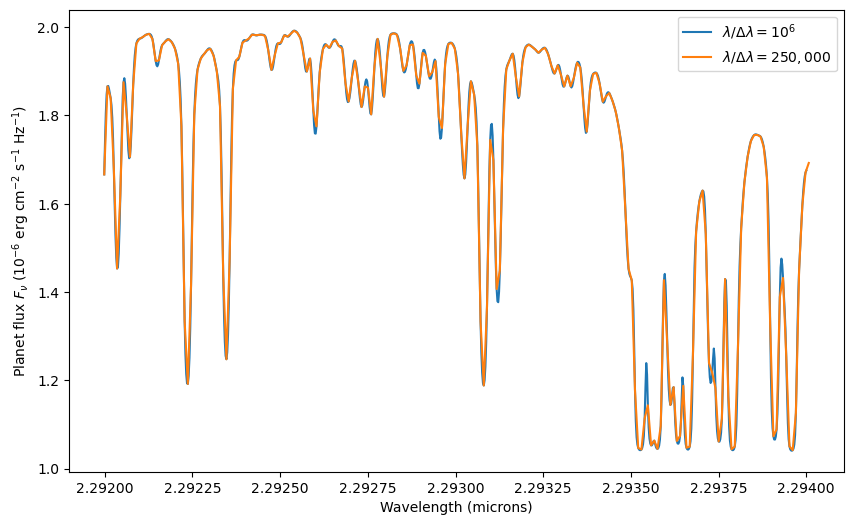

In [22]:
from petitRADTRANS.physics import temperature_profile_function_guillot_global

planet_radius = 1.0*cst.r_jup_mean
reference_gravity = 10**3.5
reference_pressure = 0.01

pressures_bar = atmosphere_high_res.pressures*1e-6 # cgs to bar
kappa_IR = 0.01
gamma = 0.4
T_int = 200.
T_equ = 1500.

temperatures = temperature_profile_function_guillot_global(pressures_bar, kappa_IR, gamma, reference_gravity, T_int, T_equ)


mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperatures)
mass_fractions['He'] = 0.24 * np.ones_like(temperatures)
mass_fractions['1H2-16O'] = 1e-3 * np.ones_like(temperatures)
mass_fractions['12C-16O'] = 1e-2 * np.ones_like(temperatures)

            #  2.33 is a typical value for H2-He dominated atmospheres
mean_molar_masses = 2.33 * np.ones_like(temperatures)

frequencies_nominal, flux_nominal, _ = atmosphere_high_res.calculate_flux(temperatures=temperatures, 
                                                 mass_fractions=mass_fractions, 
                                                 mean_molar_masses = mean_molar_masses,
                                                 reference_gravity = reference_gravity,
                                                 frequencies_to_wavelengths=False)

frequencies_lower_res, flux_lower_res, _ = atmosphere_lower_res.calculate_flux(temperatures=temperatures, 
                                                 mass_fractions=mass_fractions, 
                                                 mean_molar_masses = mean_molar_masses,
                                                 reference_gravity = reference_gravity,
                                                 frequencies_to_wavelengths=False)

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(cst.c/frequencies_nominal/1e-4, flux_nominal/1e-6,label=r'$\lambda / \Delta \lambda = 10^6$')
ax.plot(cst.c/frequencies_lower_res/1e-4, flux_lower_res/1e-6,label=r'$\lambda / \Delta \lambda = 250,000$')

ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
plt.legend()
plt.show()

Again, the numerically calculated resolution is consistent with what we requested:

Text(0, 0.5, '$\\lambda/\\Delta\\lambda$ ($10^6$)')

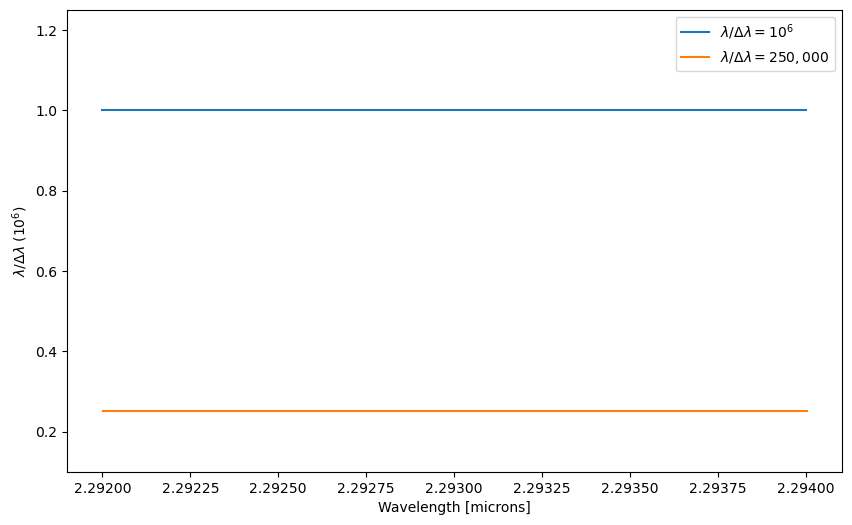

In [31]:
fig, ax = plt.subplots(figsize = (10,6))

frequencies_nominal_mean = (frequencies_nominal[1:] + frequencies_nominal[:-1])/2.
ax.plot(cst.c/frequencies_nominal_mean*1e4,
        -frequencies_nominal_mean/np.diff(frequencies_nominal)/1e6,
        label=r'$\lambda / \Delta \lambda=10^6$')

frequencies_lower_res_mean = (frequencies_lower_res[1:] + frequencies_lower_res[:-1])/2.
ax.plot(cst.c/frequencies_lower_res_mean*1e4,
        -frequencies_lower_res_mean/np.diff(frequencies_lower_res)/1e6,
        label=r'$\lambda / \Delta \lambda=250,000$')

plt.ylim([0.1,1.25])
plt.legend()
ax.set_xlabel('Wavelength [microns]')
ax.set_ylabel(r'$\lambda/\Delta\lambda$ ($10^6$)')

<div class="alert alert-warning">

Please always check that the difference between the downsampled spectrum and the spectrum at nominal resolution is negligible when both are binned down to the actual resolution of the data that you want to compare to.

</div>

## Wavelength binning vs. spectral resolution